In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from fastai.vision.all import *
from PIL import Image
import os
import shutil
import pathlib
import torch
from os import listdir
from os.path import isfile, join

In [2]:
# load the segmentation masks (in run-length encoding format)
masks_rle = pd.read_csv('../airbus_dataset/train_ship_segmentations_v2.csv').set_index('ImageId')

# select the names of images that have a ship
# 
# images that have a ship have str as the type of EncodedPixels, while images that 
# do not have a ship have float as the type of EncodedPixels
# 
# reference for lambda function: https://stackoverflow.com/questions/39275533/select-row-from-a-dataframe-based-on-the-type-of-the-objecti-e-str
ship_images = masks_rle[masks_rle['EncodedPixels'].apply(lambda x: isinstance(x, str))].index.unique().tolist()

# # get the list of no ship images
no_ship_images = list(set(os.listdir('../airbus_dataset/train_v2')) - set(ship_images))

print('Number of images with ships:', len(ship_images))
print('Number of images without ships:', len(no_ship_images))

Number of images with ships: 42556
Number of images without ships: 150000


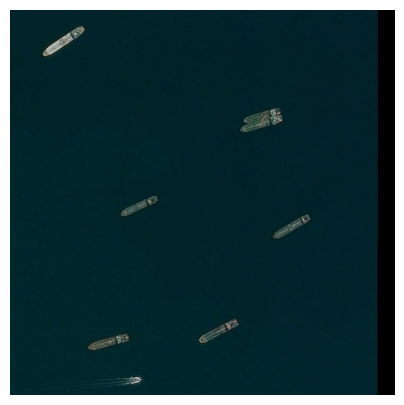

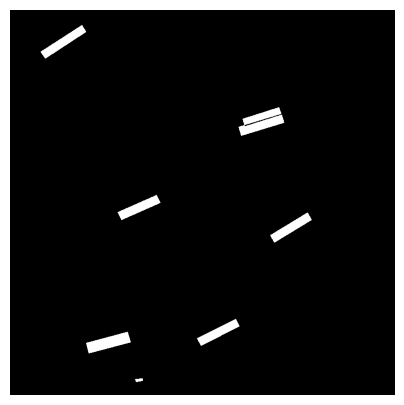

In [3]:
# generate the full image mask of an image from run-length encoding
def get_image_mask(image_id):
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    for mask in masks_rle.loc[image_id:image_id]['EncodedPixels']: 
        if isinstance(mask, str):
            mask = mask.split()
            mask = [int(i) for i in mask]
            for i in range(0, len(mask), 2):
                image_mask[mask[i]:mask[i]+mask[i+1]] = 1

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

img_id = '0e9014ce4.jpg'
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(np.array(Image.open('../airbus_dataset/train_v2/' + img_id)))
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(get_image_mask(img_id), cmap='Greys_r')


In [4]:
# save all the masks (targets) as png files
#   path - folder in which to save the images
#   images - images for which to save masks
def save_masks_png(path, images):

    # loop through all images that have at least a ship
    for image in images:

        # get the corresponding mask as numpy array
        mask = get_image_mask(image)
        mask_img = Image.fromarray(mask).convert('RGB')
        mask_img.save(path + image[:-4] + '_P.png')

# save_masks_png('../airbus_dataset/train_v2_labels/', selected_no_ship_images)

# check how many files are in the labels directory
c = 0
for file in os.listdir('../airbus_dataset/train_v2_labels/'):
    c += 1
print('Number of labels:', c)

Number of labels: 87240


## Train-Test Splits

Construct train and test splits as follows:
- **train**: only ship images (80% of the total number of ship images)
- **test**: the rest of the 20% of the ship images and no ship images such that there are 16% ship images and 84% no ship images in the test set (same stratification as the SatCen dataset)

### Split the Ship Images

Split the ship images: 80% in the train subset and 20% in the test subset.

In [17]:
# # split the images
# train_images, test_images = train_test_split(ship_images, train_size=0.8, random_state=0)

# # remove all images from the folders
# for file in os.listdir('../airbus_dataset/splits/train/images'):
#     os.remove('../airbus_dataset/splits/train/images/' + file)

# for file in os.listdir('../airbus_dataset/splits/test/images'):
#     os.remove('../airbus_dataset/splits/test/images/' + file)

# # copy the images into the respective folders
# for file in train_images:
#     src = '../airbus_dataset/train_v2/' + file
#     dst = '../airbus_dataset/splits/train/images/' + file
#     shutil.copy(src, dst)

# for file in test_images:
#     src = '../airbus_dataset/train_v2/' + file
#     dst = '../airbus_dataset/splits/test/images/' + file
#     shutil.copy(src, dst)

### Add No Ship Images

Add no ship images to the test set (*airbus_dataset/splits/test/images/* folder).

In [18]:
# # determine the number of no ship images necessary
# # in order to establish 16% positive observations and
# # 84% negative observations
# no_ship_imgs_required = math.ceil((84 / 16) * (0.2 * len(ship_images)))

# # randomly select the required number of no ship images
# selected_no_ship_images = random.sample(no_ship_images, k=no_ship_imgs_required)

# # copy the images into the target folder
# for file in selected_no_ship_images:
#     src = '../airbus_dataset/train_v2/' + file
#     dst = '../airbus_dataset/splits/test/images/' + file
#     shutil.copy(src, dst)

In [5]:
train_images = os.listdir('../airbus_dataset/splits/train/images')
test_images = os.listdir('../airbus_dataset/splits/test/images')

print(f'Number of train images: {len(train_images)}')
num_positive_train_images = len(set(train_images) & set(ship_images))
num_negative_train_images = len(set(train_images) & set(no_ship_images))
print(f'Positive examples: {num_positive_train_images} ({ 100 * num_positive_train_images / len(train_images):.2f}%)')
print(f'Negative examples: {num_negative_train_images} ({ 100 * num_negative_train_images / len(train_images):.2f}%)')

print()

print(f'Number of test images: {len(test_images)}')
num_positive_test_images = len(set(test_images) & set(ship_images))
num_negative_test_images = len(set(test_images) & set(no_ship_images))
print(f'Positive examples: {num_positive_test_images} ({ 100 * num_positive_test_images / len(test_images):.2f}%)')
print(f'Negative examples: {num_negative_test_images} ({ 100 * num_negative_test_images / len(test_images):.2f}%)')

Number of train images: 34044
Positive examples: 34044 (100.00%)
Negative examples: 0 (0.00%)

Number of test images: 53196
Positive examples: 8512 (16.00%)
Negative examples: 44684 (84.00%)


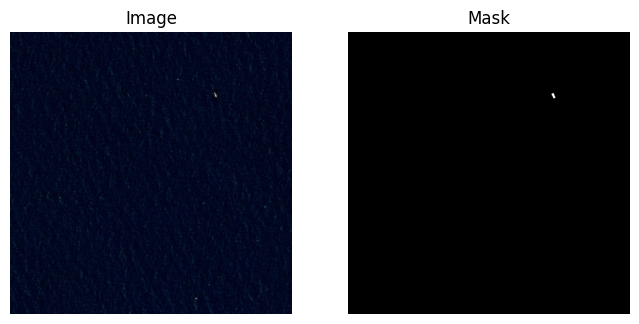

Size of training set: 34044
Size of test set: 53196


In [6]:
# get the path of the current working directory
path = pathlib.Path().resolve()

# define a function that gets the label for a given image
def label_func(fn): return path/"../airbus_dataset/train_v2_labels"/f"{fn.stem}_P.png"

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(path/'../airbus_dataset'/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    item_tfms=Resize(224) # resize images to 224x224
)

# create a dataset from the datablock
dsets = dblock.datasets(path/'../airbus_dataset/splits/')

# show an example of training image and its corresponding mask
fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(dsets.train[0][0])
plt.axis('off')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.imshow(dsets.train[0][1], cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

# double check size of train and test (called "valid" by fast.ai) sets
print(f'Size of training set: {len(dsets.train)}')
print(f'Size of test set: {len(dsets.valid)}')

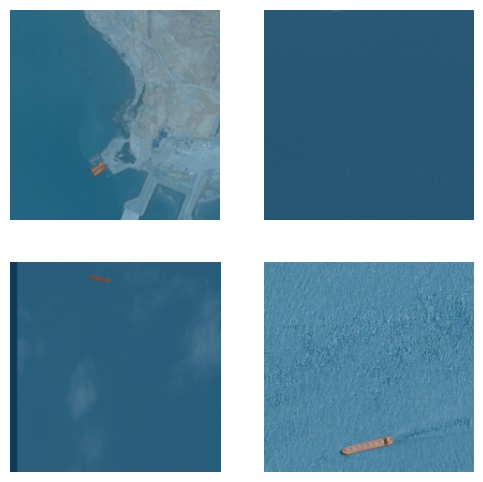

In [7]:
# create a dataloader
dls = dblock.dataloaders(path/'../airbus_dataset/splits/', bs=4, device=torch.device('cuda'))
dls.show_batch()

In [8]:
# define activation function
def focalLossActivation(self, x:Tensor) -> Tensor:
    return F.softmax(x, dim=1)

# define loss function
def focalLossDecodes(self, x:Tensor) -> Tensor:
    return x.argmax(dim=1)

# attach the functions to focal loss
FocalLoss.activation = focalLossActivation
FocalLoss.decodes = focalLossDecodes

# create a unet learner
learn = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

learn.summary()

/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DynamicUnet (Input shape: 4 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     4 x 192 x 56 x 56   
Conv2d                                    110592     False     
BatchNorm2d                               384        True      
____________________________________________________________________________
                     4 x 192 x 28 x 28   
MaxPool2d                                   

In [ ]:
# # torch.cuda.init()
# # os.environ['CUDA_VISIBLE_DEVICES']='2'

# ### 1st TRAINING PHASE ###
# # freeze encoder
# # one cycle policy
# # lr = 1e-4
# # 3 epochs
# learn.fit_one_cycle(3)

# ### 2nd TRAINING PHASE ###
# # unfreeze encoder
# # 4 more epochs
# # other hyperparameters are the same
# learn.unfreeze()
# learn.fit_one_cycle(4)

# # same the model
# print('Saving model...')
# learn.save('unet_airbus_80_20')
# print('Saved model!')

epoch,train_loss,valid_loss,time
0,0.001649,0.001418,1:36:41
1,0.001076,0.001075,1:36:33
2,0.000843,0.000942,1:36:44


epoch,train_loss,valid_loss,time
0,0.000974,0.001203,1:37:55
1,0.000676,0.000845,1:37:51
2,0.000585,0.000723,1:37:52
3,0.000570,0.000702,1:37:50


Saving model...
Saved model!


# Testing

Test the model as a binary classifier.

## Load the Model

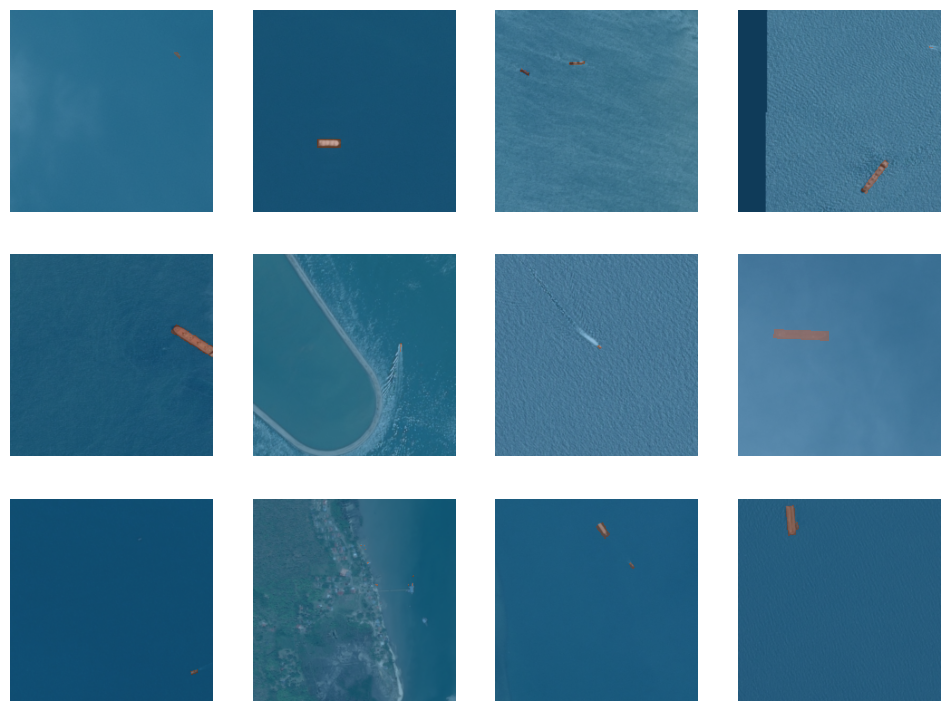

In [9]:
# define a function that gets the label for a given image
def label_func(fn): return path/"../airbus_dataset/train_v2_labels"/f"{fn.stem}_P.png"

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(path/'../airbus_dataset'/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=GrandparentSplitter(train_name='train', valid_name='test'),
    item_tfms=Resize(224) # resize images to 224x224
)

# create a dataset from the datablock
dsets = dblock.datasets(path/'../airbus_dataset/splits/')
dls = dblock.dataloaders(path/'../airbus_dataset/splits/', bs=16, device=torch.device('cuda'))
dls.show_batch(max_n=12)

# create a unet learner
unet = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

unet.load('unet_airbus_80_20')

## Construct the Ground Truth

Images in the fast.ai test dataset (*dsets.valid*) are in the same order as in the *airbus_dataset/splits/test/images* folder. 

Construct the ground truth label by looping through all images in the *airbus_dataset/splits/test/images* folder and appending to the ground truth array *y* 1 or 0 depending whether it contains a ship or not (determine if an image contains a ship or not by referencing the previously created *ship_images* and *no_ship_images* lists).

In [11]:
# array holding binary ground truth labels
y_test = []

# loop through all the images
for img in os.listdir('../airbus_dataset/splits/test/images/'):
    
    # image contains a ship
    if img in ship_images:
        y_test.append(1)
        
    # image does not contain a ship
    else: 
        y_test.append(0)

## Perform Inference on the Test Set

Pass each test image through the model, and store the greatest ship-related probability as the decision score. The raw outputs have already been passed through the softmax activation function.

In [70]:
# # decision scores
# z = []

# # do not display progress bar
# with unet.no_bar():

#     # loop through the validation images
#     for i, entry in enumerate(dsets.valid):
        
#         # perform inference
#         prediction = unet.predict(entry[0])[2]
        
#         # store the greatest ship related probability
#         z.append(torch.max(prediction[1]))
        
#         # report image number
#         if i % 1000 == 0:
#             print(f'Image number: {i + 1}')

Image number: 1
Image number: 1001
Image number: 2001
Image number: 3001
Image number: 4001
Image number: 5001
Image number: 6001
Image number: 7001
Image number: 8001
Image number: 9001
Image number: 10001
Image number: 11001
Image number: 12001
Image number: 13001
Image number: 14001
Image number: 15001
Image number: 16001
Image number: 17001
Image number: 18001
Image number: 19001
Image number: 20001
Image number: 21001
Image number: 22001
Image number: 23001
Image number: 24001
Image number: 25001
Image number: 26001
Image number: 27001
Image number: 28001
Image number: 29001
Image number: 30001
Image number: 31001
Image number: 32001
Image number: 33001
Image number: 34001
Image number: 35001
Image number: 36001
Image number: 37001
Image number: 38001
Image number: 39001
Image number: 40001
Image number: 41001
Image number: 42001
Image number: 43001
Image number: 44001
Image number: 45001
Image number: 46001
Image number: 47001
Image number: 48001
Image number: 49001
Image number:

### Save Decision Scores for Future Use

In [73]:
# np.save('../airbus_dataset/test_set_decision_scores', z)

### Load the Pre-computed Decision Scores

In [12]:
z = np.load('../airbus_dataset/test_set_decision_scores.npy')

## Plot Curves

### ROC

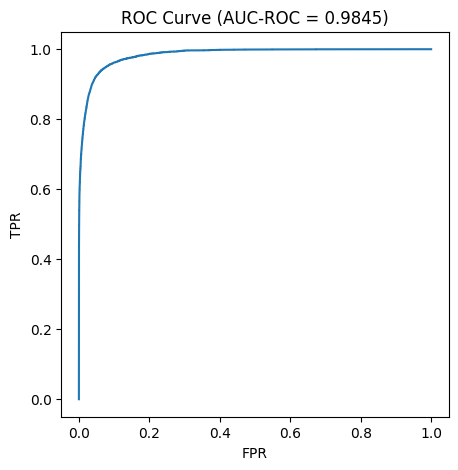

In [21]:
fprs, tprs, _ = roc_curve(y_test, z)
plt.figure(figsize=(5,5))
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC Curve (AUC-ROC = {auc(fprs, tprs):.4f})')
plt.show()

### PR

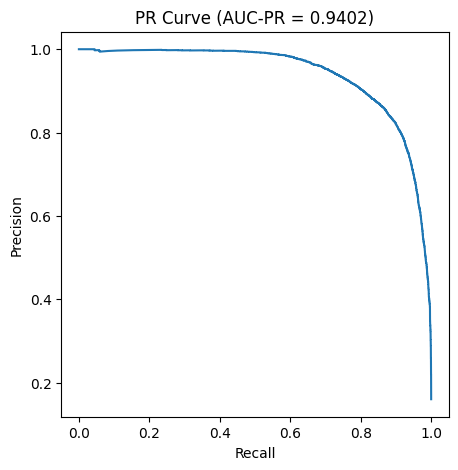

In [20]:
precisions, recalls, _ = precision_recall_curve(y_test, z)
plt.figure(figsize=(5,5))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR Curve (AUC-PR = {auc(recalls, precisions):.4f})')
plt.show()